# Trafic Accidents in NYC

See the webpage for supplementary descriptions.
* [link to d3 home page](https://titanbender.github.io) 
* [link to git repo](https://github.com/titanbender/titanbender.github.io)

In [1]:
from IPython.display import VimeoVideo
VimeoVideo("211653855",width=640, height=360)

In [2]:
# Import libraries
import json
import numpy as np
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import collections 
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
import datetime as dt
import geoplotlib
from geoplotlib.utils import BoundingBox
from sklearn import neighbors

/Users/Bender/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Create JSON function 
def createJSON(my_dict, file_name):
    with open(file_name, 'w') as outfile:
        json.dump(my_dict, outfile)
        outfile.close()

In [4]:
# Create geojson
def parseJson(year,file_name):
    # number of obs. 
    tmp_DF = raw_DF[raw_DF["YEAR"] == year]
    #
    tmp_lat = list(tmp_DF["LATITUDE"])
    tmp_lon = list(tmp_DF["LONGITUDE"])
    tmp_hour = list(tmp_DF["HOUR"])
    tmp_borough = list(tmp_DF["BOROUGH"])
    # 
    N_tot = len(tmp_lat)
    
    # output
    out_dict = [{'lat': tmp_lat[ii],
                 'lon': tmp_lon[ii],
                 'r': 1} for ii in range(0,N_tot)]
    #
    createJSON(out_dict, file_name) 

## 1. Motivation
### - What is your dataset?

The final assignment utilized two different data sources: <br> <br>
1) The NYPD Motor Vehicle Collisions Data which can be downloaded from NYC Open Data: <br> https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data <br>
The data set is also downloadable from the following link: <br>
https://drive.google.com/file/d/0B42GL3RvQcSCWmNSMUxXazFrajQ/view <br>

2) Weather data from the National Centers For Environmental Information. Information can be found online: <br>
https://www.ncei.noaa.gov/ <br>
The specific data set is also downloadable from the following link: <br>
https://drive.google.com/file/d/0B0TAr0IxUyZrQzF1QmJfSzRWTkU/view?usp=sharing <br>

### - Why did you choose this/these particular dataset(s)?

The datasets were chosen for three main reasons. First, as citizens we're familiar with the dangers of trafic. Therefore we thought it would be interesting to explore if this form of danger can be predicted and whether factors such as weather plays an important role. Second, the motorvehicle accident dataset is a large data set which is suitable for machine learning tools that require lots of training data. Third, the weather data allowed us to explore the hypothises that heavy rain leads to more trafic accidents.


### - What was your goal for the end user's experience?

The goal of the end user experience is to provide data analysis and visualations that empowers NYPD to understand the patterns for accidents better (season, time of day, etc.) and potentially create a predictive tool for lethal accidents .

## 2. Basic stats. Let's understand the dataset better
### - A) Write about your choices in data cleaning and preprocessing

As we're working with two different datasets, the first step was to transform values for dates in the weather dateset to match the motorvehicle accident dataset. Inside the motorvehicle accident dataset, extra columns were added in order to examine how time of day and season impacts accidents. Further, unused columns were deleted to free up space.


NOTE: For readability the second answer to section 2 is located closer to the statistical output

In [5]:
# Load weather data
weather_DF = pd.read_csv("data/weather.csv", low_memory = False)

dateList = list(weather_DF['DATE'])

# transforming the date format to fit the other data set 
newDateList = []
for x in dateList:
    x = str(x)
    year = str(x[:4])
    month = str(x[4:6]) +"/"
    date = str(x[6:8]) +"/"
    tmp = month + date + year
    newDateList.append(tmp)

# adding the transformed date list to the accident data frame
weather_DF['DATE'] = newDateList

In [6]:
# Load accident data
raw_DF = pd.read_csv("data/raw_data.csv", low_memory = False)

# Getting year
year = raw_DF["DATE"].apply(lambda x: x.split('/'))
raw_DF["YEAR"] = year.apply(lambda x: int(x[2]))

# Getting hour
hour = raw_DF["TIME"].apply(lambda x: x.split(':'))
raw_DF["HOUR"] = hour.apply(lambda x: int(x[0]))
raw_DF["TIME_DEC"] = hour.apply(lambda x: float(int(x[0]) + int(x[1])/60) )

# String values for month
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']

# Getting month
month = raw_DF["DATE"].apply(lambda x: x.split('/'))
# raw_DF["MONTH"] = month.apply(lambda x: month_list[int(x[0])-1])
raw_DF["MONTH"] = month.apply(lambda x: int(x[0]))

# create bool variable KNN_bool = [0 or 1]. 0 if persons not are injured nor killed otherwise 1...
raw_DF['KNN_bool'] = raw_DF[['NUMBER OF PERSONS INJURED',
                             'NUMBER OF PERSONS KILLED']].apply(lambda x: 1 if (x['NUMBER OF PERSONS INJURED'] + 
                                                                                x['NUMBER OF PERSONS KILLED']) > 0 
                                                                else 0, axis=1)

# remove unused columns
raw_DF = raw_DF.drop(['ZIP CODE',
                          'LOCATION',
                          'UNIQUE KEY',
                          'ON STREET NAME',
                          'CROSS STREET NAME',
                          'OFF STREET NAME'], axis = 1)

    
raw_DF.head()
# raw_DF.shape

,DATE,TIME,BOROUGH,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,...,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,YEAR,HOUR,TIME_DEC,MONTH,KNN_bool
0,12/31/2016,0:05,MANHATTAN,40.731659,-73.985445,0,0,0,0,0,...,TAXI,TAXI,NaN,NaN,NaN,2016,0,0.083333,12,0
1,12/31/2016,0:00,BRONX,40.826258,-73.882463,0,0,0,0,0,...,TAXI,NaN,NaN,NaN,NaN,2016,0,0.000000,12,0
2,12/31/2016,0:00,BROOKLYN,40.684475,-73.974058,0,0,0,0,0,...,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,2016,0,0.000000,12,0
3,12/31/2016,0:00,BROOKLYN,40.685180,-73.933487,0,0,0,0,0,...,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,2016,0,0.000000,12,0
4,12/31/2016,0:00,BROOKLYN,40.646707,-73.965467,0,0,0,0,0,...,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,2016,0,0.000000,12,0


## 2. Basic stats. Let's understand the dataset better
### -  B) Write a short section that discusses the dataset stats

In the practical Info section below, you will find some basic statistics from the datasets. As the focus on the assignment is on the assisting NYPD in understanding patterns, the focus of the section was to shed light on trends within the different years and boroughs. An element that stands out is the fact that 2016 has about 100 less accidents per day compared to the other years. 2016 also has the largest outlier with about just one accident on one of the particular days compared to average of 424. 2016 also includes the days with the 10 least accident observations, which all but one is in August. The only outside of August is an observation in September 

### Practical Info

Preparing calculations for the basic statistical overview

In [7]:
pra_info = {}

# First day of observations
pra_info['first obs'] = min(raw_DF["DATE"])

# Last day of observations
pra_info['last obs'] = max(raw_DF["DATE"])

# pra_info['unique year'] = list(set(raw_DF['YEAR']))
pra_info['unique year'] = [2013,2014,2015,2016]

# accident per year
pra_info['N'] = {}
tmp = []
for ii in pra_info['unique year']:
    pra_info['N'][ii] = len(raw_DF[raw_DF['YEAR'] == ii])
    tmp.append(pra_info['N'][ii])
# sum tot
pra_info['N']['tot'] = sum(tmp)

pra_info['unique borough'] = list(set(raw_DF['BOROUGH']))
pra_info['borough'] = {}
for ii in pra_info['unique borough']:
    pra_info['borough'][ii] = {}
    tmp = []
    for jj in pra_info['unique year']:
        pra_info['borough'][ii][jj] = len(raw_DF[(raw_DF['YEAR'] == jj) & (raw_DF['BOROUGH'] == ii)])
        tmp.append(pra_info['borough'][ii][jj])   
    # sum tot
    pra_info['borough'][ii]['tot'] = sum(tmp)
    
# obs per month
pra_info['unique months'] = list(set(raw_DF['MONTH']))
pra_info['N month'] = {}
for ii in pra_info['unique months']:
    pra_info['N month'][ii] = {}
    tmp = []
    for jj in pra_info['unique year']:
        pra_info['N month'][ii][jj] = len(raw_DF[(raw_DF['YEAR'] == jj) & (raw_DF['MONTH'] == ii)])
        tmp.append(pra_info['N month'][ii][jj])
        
    # sum tot
    pra_info['N month'][ii]['tot'] = sum(tmp)
    
# ratio
pra_info['ratio'] = {}
for ii in pra_info['unique borough']:
    pra_info['ratio'][ii] = {}
    for jj in pra_info['unique year']+['tot']:
        pra_info['ratio'][ii][jj] = pra_info['borough'][ii][jj] / pra_info['N'][jj] 
        
# ratio month
pra_info['ratio month'] = {}
for ii in pra_info['unique months']:
    pra_info['ratio month'][ii] = {}
    for jj in pra_info['unique year']:
        pra_info['ratio month'][ii][jj] = pra_info['N month'][ii][jj] / pra_info['N'][jj]
        
# obs per day
pra_info['unique days'] = list(set(raw_DF['DATE']))
pra_info['No. days'] = {}
for ii in pra_info['unique days']:
    pra_info['No. days'][ii] = len(raw_DF[raw_DF['DATE'] == ii])
    
# avg counting
tmp = [int(pra_info['No. days'].keys()[ii].split('/')[2]) for ii in range(0, len(pra_info['No. days']))]
tmp_days = collections.Counter(tmp)
tmp_days['tot'] = len(pra_info['No. days'])

pra_info['avg day'] = {}
for ii in pra_info['unique year']+['tot']:
        pra_info['avg day'][ii] =  pra_info['N'][ii] / tmp_days[ii]
        
pra_info['avg year'] = {}
for ii in pra_info['unique year']:
        pra_info['avg year'][ii] =  pra_info['N'][ii] / len(pra_info['unique year'])


Printing out the basic statistical overview

In [8]:
# Pratical data information prints
print "First day of observations:", min(raw_DF["DATE"])
print "Last day of observations:", max(raw_DF["DATE"])
print "Total number of obs. in mentioned period:" , len(raw_DF['DATE'])
print ""
print "Accidents per year:"
print pra_info['avg year']
print ""
print "Average accidents per day in mm:"
print pra_info['avg day'] 
print ""
print "Day with most accidents"
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=True)[0]
print ""
print "Day with least accidents"
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=False)[0]
print ""
print "Top 10 days with most accidents:" 
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=True)[0:10]
print ""
print "Top 10 days with least accidents:" 
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=False)[0:10]

First day of observations: 01/01/2013
Last day of observations: 12/31/2016
Total number of obs. in mentioned period: 601313

Accidents per year:
{2016: 31411.25, 2013: 38989.5, 2014: 39073.25, 2015: 40854.25}

Average accidents per day in mm:
{2016: 343.29234972677597, 'tot': 411.5763175906913, 2013: 427.2821917808219, 2014: 428.2, 2015: 447.7178082191781}

Day with most accidents
('01/21/2014', 843)

Day with least accidents
('08/10/2016', 1)

Top 10 days with most accidents:
[('01/21/2014', 843), ('02/03/2014', 776), ('03/06/2015', 715), ('03/08/2013', 703), ('01/18/2015', 692), ('03/05/2015', 675), ('11/26/2013', 656), ('02/14/2014', 645), ('06/07/2013', 623), ('11/19/2015', 622)]

Top 10 days with least accidents:
[('08/10/2016', 1), ('08/14/2016', 2), ('08/22/2016', 3), ('08/12/2016', 3), ('08/31/2016', 3), ('08/17/2016', 4), ('09/25/2016', 4), ('08/23/2016', 4), ('08/06/2016', 5), ('08/21/2016', 5)]


One instersting statistical pattern is that average accident per day is significatnly lower for 2016 compared to the other years. 2016 also include the days with lowest observation counts. Does this mean that 2016 just have more outliers or that most days on a consistent basis is lower than the average in the other years? We will explore this in the Time Series section 

## Below are some simple data analysis for website visualization

### Bar plot

The bar plot below is seperated in 24 slots: One for each hour in the day. The reason for this analysis is to understand which hours during the day might be most dangerous for you. Calculations are furhter seperated into boroughs to understand the danger for the individual districts.

In [9]:
# Time frame
tmp_x_key = ["00:00-00:59","01:00-01:59","02:00-02:59","03:00-03:59","04:00-04:59","05:00-05:59",
             "06:00-06:59","07:00-07:59","08:00-08:59","09:00-09:59","10:00-10:59","11:00-11:59",
             "12:00-12:59","13:00-13:59","14:00-14:59","15:00-15:59","16:00-16:59","17:00-17:59",
             "18:00-18:59","19:00-19:59","20:00-20:59","21:00-21:59","22:00-22:59","23:00-23:59"]

# init lists
bar_dict_NYC = []
bar_dict_BRONX = []
bar_dict_BROOKLYN = []
bar_dict_STATEN_ISLAND = []
bar_dict_MANHATTAN = []
bar_dict_QUEENS = []
# injured
bar_dict_NYC_inj = []
bar_dict_BRONX_inj = []
bar_dict_BROOKLYN_inj = []
bar_dict_STATEN_ISLAND_inj = []
bar_dict_MANHATTAN_inj = []
bar_dict_QUEENS_inj = []
# killed
bar_dict_NYC_kill = []
bar_dict_BRONX_kill = []
bar_dict_BROOKLYN_kill = []
bar_dict_STATEN_ISLAND_kill = []
bar_dict_MANHATTAN_kill = []
bar_dict_QUEENS_kill = []

# loop through each time frame
for ii in range(0,24):
    #print ii
    tmp_borough = {}
    tmp_borough_inj = {}
    tmp_borough_kill = {}
    for jj in pra_info['unique borough']:
        #print 's'
        tmp_borough[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii)])
        tmp_borough_inj[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii) & 
                                     (raw_DF['NUMBER OF PERSONS INJURED'] > 0)])
        tmp_borough_kill[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii) & 
                                     (raw_DF['NUMBER OF PERSONS KILLED'] > 0)])
        
    # sum all for given time slot
    tmp_sum = np.sum(tmp_borough.values())
    tmp_sum_inj = np.sum(tmp_borough_inj.values())
    tmp_sum_kill = np.sum(tmp_borough_kill.values())
    
    # append time slot to list
    bar_dict_NYC.append({'key': tmp_x_key[ii], 'value': tmp_sum})
    bar_dict_BRONX.append({'key': tmp_x_key[ii], 'value': tmp_borough['BRONX']})
    bar_dict_BROOKLYN.append({'key': tmp_x_key[ii], 'value': tmp_borough['BROOKLYN']})
    bar_dict_STATEN_ISLAND.append({'key': tmp_x_key[ii], 'value': tmp_borough['STATEN ISLAND']})
    bar_dict_MANHATTAN.append({'key': tmp_x_key[ii], 'value': tmp_borough['MANHATTAN']})
    bar_dict_QUEENS.append({'key': tmp_x_key[ii], 'value': tmp_borough['QUEENS']})
    
    # append observations for injuries
    bar_dict_NYC_inj.append({'key': tmp_x_key[ii], 'value': tmp_sum_inj})
    bar_dict_BRONX_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['BRONX']})
    bar_dict_BROOKLYN_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['BROOKLYN']})
    bar_dict_STATEN_ISLAND_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['STATEN ISLAND']})
    bar_dict_MANHATTAN_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['MANHATTAN']})
    bar_dict_QUEENS_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['QUEENS']})
    
    # append observations for deadly outcomes
    bar_dict_NYC_kill.append({'key': tmp_x_key[ii], 'value': tmp_sum_kill})
    bar_dict_BRONX_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['BRONX']})
    bar_dict_BROOKLYN_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['BROOKLYN']})
    bar_dict_STATEN_ISLAND_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['STATEN ISLAND']})
    bar_dict_MANHATTAN_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['MANHATTAN']})
    bar_dict_QUEENS_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['QUEENS']})
    
# create bar jsons 
createJSON(bar_dict_NYC, 'data/bar_dict_NYC.json')
createJSON(bar_dict_BRONX, 'data/bar_dict_BRONX.json')
createJSON(bar_dict_BROOKLYN, 'data/bar_dict_BROOKLYN.json')
createJSON(bar_dict_STATEN_ISLAND, 'data/bar_dict_STATEN_ISLAND.json')
createJSON(bar_dict_MANHATTAN, 'data/bar_dict_MANHATTAN.json')
createJSON(bar_dict_QUEENS, 'data/bar_dict_QUEENS.json')

createJSON(bar_dict_NYC_inj, 'data/bar_dict_NYC_inj.json')
createJSON(bar_dict_BRONX_inj, 'data/bar_dict_BRONX_inj.json')
createJSON(bar_dict_BROOKLYN_inj, 'data/bar_dict_BROOKLYN_inj.json')
createJSON(bar_dict_STATEN_ISLAND_inj, 'data/bar_dict_STATEN_ISLAND_inj.json')
createJSON(bar_dict_MANHATTAN_inj, 'data/bar_dict_MANHATTAN_inj.json')
createJSON(bar_dict_QUEENS_inj, 'data/bar_dict_QUEENS_inj.json')

createJSON(bar_dict_NYC_kill, 'data/bar_dict_NYC_kill.json')
createJSON(bar_dict_BRONX_kill, 'data/bar_dict_BRONX_kill.json')
createJSON(bar_dict_BROOKLYN_kill, 'data/bar_dict_BROOKLYN_kill.json')
createJSON(bar_dict_STATEN_ISLAND_kill, 'data/bar_dict_STATEN_ISLAND_kill.json')
createJSON(bar_dict_MANHATTAN_kill, 'data/bar_dict_MANHATTAN_kill.json')
createJSON(bar_dict_QUEENS_kill, 'data/bar_dict_QUEENS_kill.json')

View the barplot here: titanbender.github.io

One pattern that appearsis that both injuries and deadly accidents appear more frequently in the late afternoon. Whereas the number of injuries varies more throughout the day (although often a smooth trend), the number of deadly accidents doesn't vary as much.

### Time Series

The purpose of the time series is to understand how accidents are distributed across months for pedestrians, cyclists, motorists and all of them aggregated. A visualization of the time series will help the police understand which months are the most critical and also which types of civilians that are in particular danger throughout the year. 

In [10]:
# Time Series
ts_json_tot = []; ts_json_ped = []; ts_json_cyc = []
ts_json_mot = []; ts_json_NYC = []

# loop for each day
for dd in pra_info['unique days']:
    # init temp dict
    tmp_tot = {}
    tmp_ped = {}
    tmp_cyc = {}
    tmp_mot = {}

    # loop for each borough
    for bb in pra_info['unique borough']:
        # init dict
        tmp_tot[bb] = {}
        tmp_ped[bb] = {}
        tmp_cyc[bb] = {}
        tmp_mot[bb] = {}
        # add date
        tmp_tot[bb]['date'] = dd
        tmp_ped[bb]['date'] = dd
        tmp_cyc[bb]['date'] = dd
        tmp_mot[bb]['date'] = dd
        # find indices for unique day and unique borough
        tmp_idx = list(raw_DF[(raw_DF['DATE'] == dd) & (raw_DF['BOROUGH'] == bb)].index)
        #
        tmp_ped[bb]['inj'] = np.sum(raw_DF['NUMBER OF PEDESTRIANS INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_ped[bb]['kill'] = np.sum(raw_DF['NUMBER OF PEDESTRIANS KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_ped[bb]['tot'] = (tmp_ped[bb]['inj'] + tmp_ped[bb]['kill'])
        
        tmp_cyc[bb]['inj'] = np.sum(raw_DF['NUMBER OF CYCLIST INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_cyc[bb]['kill'] = np.sum(raw_DF['NUMBER OF CYCLIST KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_cyc[bb]['tot'] = (tmp_cyc[bb]['inj'] + tmp_cyc[bb]['kill'])
        
        tmp_mot[bb]['inj'] = np.sum(raw_DF['NUMBER OF MOTORIST INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_mot[bb]['kill'] = np.sum(raw_DF['NUMBER OF MOTORIST KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_mot[bb]['tot'] = (tmp_mot[bb]['inj'] + tmp_mot[bb]['kill'])

        tmp_tot[bb]['inj'] = np.sum(raw_DF['NUMBER OF PERSONS INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_tot[bb]['kill'] = np.sum(raw_DF['NUMBER OF PERSONS KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_tot[bb]['tot'] = (tmp_tot[bb]['inj'] + tmp_tot[bb]['kill'])

    # append day and info to the json list
    ts_json_tot.append(tmp_tot)
    ts_json_ped.append(tmp_ped)
    ts_json_cyc.append(tmp_cyc)
    ts_json_mot.append(tmp_mot)
    
    # NYC
    tmp_idx = list(raw_DF[raw_DF['DATE'] == dd].index)
    tmp = [np.sum(raw_DF['NUMBER OF PERSONS INJURED'].iloc[tmp_idx]),# / len(tmp_idx) * 100,
           np.sum(raw_DF['NUMBER OF PERSONS KILLED'].iloc[tmp_idx])]# / len(tmp_idx) * 100]
    ts_json_NYC.append({'date': dd,
                        'inj': tmp[0],
                        'kill': tmp[1],
                        'tot': np.sum(tmp)
                       })

# create json files
for bb in pra_info['unique borough']:
    # tot
    tmp = [ts_json_tot[ii][bb] for ii in range(0,len(ts_json_tot))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_tot_' + bb + '.json')
    # ped
    tmp = [ts_json_ped[ii][bb] for ii in range(0,len(ts_json_ped))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_ped_' + bb + '.json')
    # cyc
    tmp = [ts_json_cyc[ii][bb] for ii in range(0,len(ts_json_cyc))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_cyc_' + bb + '.json')
    # mot
    tmp = [ts_json_mot[ii][bb] for ii in range(0,len(ts_json_mot))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_mot_' + bb + '.json')

# create json for NYC total
tmp = [ts_json_NYC[ii] for ii in range(0,len(ts_json_NYC))]
tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
createJSON(tmp,'data/ts/ts_NYC.json')

View the time series here: titanbender.github.io

By observing the aggregegated data for injuries, a clear pattern emerges in which accidents increase from the start of the year. Then the number of accidents peaks during the summer months and then decreases towards the end of the year.

<b>Anomoly in August 2016:</b> As mentioned in the movie and also identified in part 1, basic statistics, a lot of minimum outliers are located in August 2016. In fact, one of the days only have 1 accident and the 9 other minimum observations are also in the same period. I've done some research and believe I've found the reason. In 2016, the city of New York organized open streets throughout August, in which streets were closed for cars to make room for running biking and walking. Although the event was targeting the weekends in August, the logistics to set everything up could have hindered traffic to flow as usual and thereby minimize accidents during this period. Information about Summer Streets can be found here: http://www.nyc.gov/html/dot/summerstreets/html/home/home.shtml

### Weather correlation

One of the hypothesis made in this assignment is that rain fall impacts the number of trafic accidents. Below are the code in which a linear relationsship between the two are explored. As the data sets might not completely overlap, we had to match for the overlapping dates first.

In [11]:
# Create lists for rain fall and unique dates
rainList = list(weather_DF['PRCP'])

# create list of unique dates
uniqueDateList = set(newDateList)

# Creating dictionary with rain fall average per day
dayRainDic = {}
for day in uniqueDateList:
    tmp = 0
    counter = 0
    avg = 0
    for x in range(0,len(newDateList)-1):
        if day == newDateList[x]:
            # Clean rain data
            if rainList[x] >= 0:
                tmp += rainList[x]
                counter += 1
    if tmp != 0:
        avg = tmp / counter
        dayRainDic[day] = avg
    else:
        dayRainDic[day] = 0
        
# adding accidents to the rain fall dictionary
accDateList = raw_DF['DATE']
setAccDateList = set(accDateList)


# Create lists for rain fall and unique dates
rainList = list(weather_DF['PRCP'])
uniqueDateList = set(newDateList)

# Creating dictionary with rain fall average per day
dayRainDic = {}
for day in uniqueDateList:
    tmp_list = []
    tmp = 0
    counter = 0
    avg = 0
    for x in range(0,len(newDateList)-1):
        if day == newDateList[x]:
            # Clean rain data
            if rainList[x] >= 0:
                tmp += rainList[x]
                counter += 1
    if tmp != 0:
        avg = tmp / counter
        tmp_list.append(avg)
        tmp_list.append(pra_info['No. days'][day])
        dayRainDic[day] = tmp_list
    else:
        tmp_list.append(0)
        tmp_list.append(pra_info['No. days'][day])
        dayRainDic[day] = tmp_list
        
# adding accidents to the rain fall dictionary
accDateList = raw_DF['DATE']
setAccDateList = set(accDateList)

In [12]:
WeatherplotX = []
WeatherplotY = []

for value in dayRainDic.values():    
    WeatherplotX.append(value[0])
    WeatherplotY.append(value[1])

In [13]:
# linear regression
from scipy import stats
from scipy.stats.stats import pearsonr

# create method to calculate alpha, beta and the plots for the regression
def least_squares_lm_fit(x, y):
    import numpy as np
    N = len(x)
    rho = stats.pearsonr(x,y)[0]
    alpha = rho * np.std(y) / np.std(x) 
    beta = np.mean(y) - alpha * np.mean(x)
    # for plotting line
    line_x = list(np.linspace(min(x), max(x), num = N))
    line_y = [beta + line_x[ii] * alpha for ii in range(0,len(line_x))]
    
    return alpha, beta, line_x, line_y

line_x = (least_squares_lm_fit(WeatherplotX, WeatherplotY)[2])
line_y = least_squares_lm_fit(WeatherplotX, WeatherplotY)[3]
alpha = least_squares_lm_fit(WeatherplotX, WeatherplotY)[0]
beta = least_squares_lm_fit(WeatherplotX, WeatherplotY)[1]
rho = pearsonr(WeatherplotX, WeatherplotY)

print alpha
print beta
print rho

1.27409541019
407.627933646
(0.079348950344849942, 0.0024041773833753635)


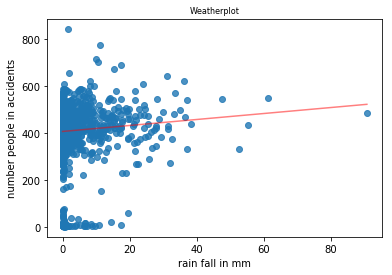

the alpha between rainfall and number of accidents is: 1.274
the number of people in accidents when there is no rainfall: 407.628
the pearson correlation between the number of people involved in accident and rain fall is: 0.079


In [14]:
# plot the results found in last step
plt.close('All')
f, axarr = plt.subplots(1, 1)
axarr.scatter(WeatherplotX, WeatherplotY, alpha=0.8)
axarr.set_title('Weatherplot', fontsize = 8)
axarr.plot(line_x, line_y, alpha=0.5, color = 'red')
axarr.set_xlabel('rain fall in mm')
axarr.set_ylabel('number people in accidents')
plt.show()
print "the alpha between rainfall and number of accidents is: {0:.3f}".format(alpha)
print "the number of people in accidents when there is no rainfall: {0:.3f}".format(beta)
print "the pearson correlation between the number of people involved in accident and rain fall is: {0:.3f}".format(rho[0])

As a pearson correlation (PR) of 0 implies no linear correlation and the PR value for rain fall and number of accidents is almost 0, it can concluded from the data set that rain fall does not have a significant impact on the number of people in trafic accidents.

## 3. Theory. Which theoretical tools did you use?

### - A) Describe which machine learning tools you use and why the tools you've chosen are right for the problem you're solving.

In order to predict the severity of a trafic acccident KNN and Decision Trees were chosen among the different machine learning tools. As we're dealing with geographic data for the accidents, KNN was an obvious choice as it is a fair hypothesis that accidents of different severity could occur in clusters. KNN analysis with geographic information is also easy to visualize, making it applicable within the scope of the course. <br> <br>
Decision trees was chosen as it is a tool whichs helps identify the right order questions to identify a specific outcome - in this case if an accident is deadly or not. Therefore, the results from a decision tree could be used as a list of questions to determine the severity of accident as it is being reported. Whether this is a good idea is determined by the tests of the training data.


## KNN

In [15]:
# Create dict for prediction tool
knn_dict = {}
knn_dict['lat'] = list(raw_DF['LATITUDE'])
knn_dict['lat_min_max'] = [np.min(knn_dict['lat']), np.max(knn_dict['lat'])]
knn_dict['lon'] = list(raw_DF['LONGITUDE'])
knn_dict['lon_min_max'] = [np.min(knn_dict['lon']), np.max(knn_dict['lon'])]
knn_dict['time'] = list(raw_DF['TIME_DEC'])
knn_dict['month'] = list(raw_DF['MONTH'])
knn_dict['year'] = list(raw_DF['YEAR'])

knn_dict['class'] = list(raw_DF['KNN_bool'])
colorList = []
for value in list(raw_DF['KNN_bool']):
                  if value == False:
                      colorList.append("rgba(255,255,0,0.5)")
                  else:
                      colorList.append("rgba(255,0,0,0.5)")
knn_dict['color'] = colorList
knn_dict['N'] = len(knn_dict['class'])

# KNN dictionaries for predictions
knn_dict['X'] = np.array([[knn_dict['lat'][ii], knn_dict['lon'][ii], knn_dict['time'][ii], knn_dict['month'][ii]] for ii in range(0,knn_dict['N'])])
# including only latitude and longtitude values
knn_dict['Basic'] = np.array([[knn_dict['lat'][ii], knn_dict['lon'][ii]] for ii in range(0,knn_dict['N'])])
# 
knn_dict['y'] = np.array([knn_dict['class'][ii] for ii in range(0,knn_dict['N'])])

# create small geo data for heatmap
knn_json = [{'lat': knn_dict['lat'][ii],
             'lon': knn_dict['lon'][ii],
             'color': knn_dict['color'][ii],
             'class': knn_dict['class'][ii]} for ii in range(0,2000)] 

# create large geo data for heatmap
knn_large_json = [{'lat': knn_dict['lat'][ii],
             'lon': knn_dict['lon'][ii],
             'color': knn_dict['color'][ii],
             'class': knn_dict['class'][ii]} for ii in range(0,knn_dict['N'])] 

# create indexes for different years
ind_2013 = []
ind_2014 = []
ind_2015 = []
ind_2016 = []
list_indexes = [ind_2013,ind_2014,ind_2015,ind_2016]

# create function for identifying indexes
def yearJson(year,ind_list):
    counter = 0
    for x in range(0,knn_dict['N']):
        if counter < 1000:
            if knn_dict['year'][x] == year:
                ind_list.append(x)
                counter += 1
                
# create list of indexes           
yearJson(2013,ind_2013)
yearJson(2014,ind_2014)
yearJson(2015,ind_2015)
yearJson(2016,ind_2016)

fileNames = ['data/knn_json_samples_2013.json', 'data/knn_json_samples_2014.json', 'data/knn_json_samples_2015.json', 'data/knn_json_samples_2016.json']

# create JSON files for all years
for x in range (0, len(list_indexes)):
    tmp = [knn_large_json[y] for y in list_indexes[x]]  
    createJSON(tmp, fileNames[x]) 

# create JSON files for sample of all the years 
import random
knn_json_samples = random.sample(knn_json, 1000)
createJSON(knn_json, 'data/knn_json.json') 
createJSON(knn_json_samples, 'data/knn_json_samples.json')

# 
tmp = collections.Counter(knn_dict['class'])
print 'Non fatal accidents: {0:.3f}%'.format(tmp.values()[0] / np.sum(tmp.values()) * 100)
print 'Fatal accidents:     {0:.3f}%'.format(tmp.values()[1] / np.sum(tmp.values()) * 100)

Non fatal accidents: 81.420%
Fatal accidents:     18.580%


Before we begin to predict the outcomes, we wanted to show the split between fatal and non-fatal accidents. As you can see the relationsship is about 4:1 for every fatal accident. This is important as overrepresented data will impact the KNN analysis. 

## 3. Theory. Which theoretical tools did you use?

### - B) Talk about your model selection. How did you split the data in to test/training. Did you use cross validation?

To determine the optimal parameters for our predictive calculations, we split our dataset into K-fold 10 and calculated the error rate as a function of the N nearest neighboors. The results of the error rate in % is displayed in a plot below. Cross validation was used in the calculations to check whether the model was under - or over-fitting.

Cross validation fold: 1/10


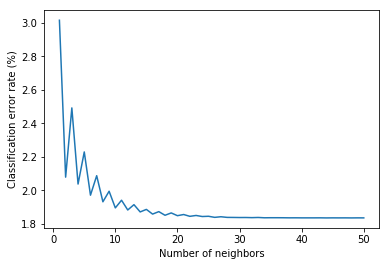

Cross validation fold: 2/10


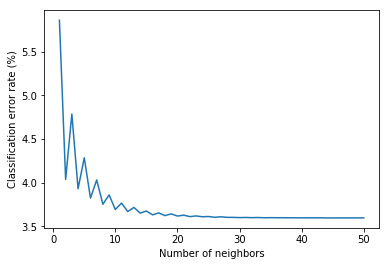

Cross validation fold: 3/10


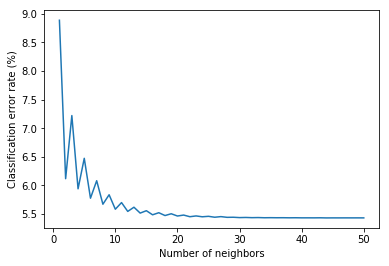

Cross validation fold: 4/10


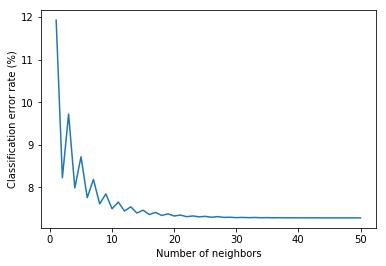

Cross validation fold: 5/10


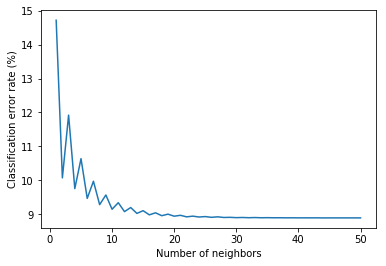

Cross validation fold: 6/10


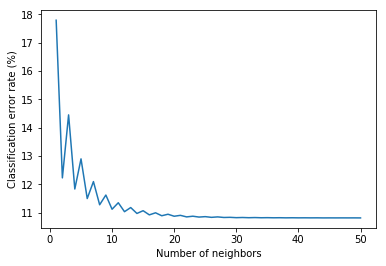

Cross validation fold: 7/10


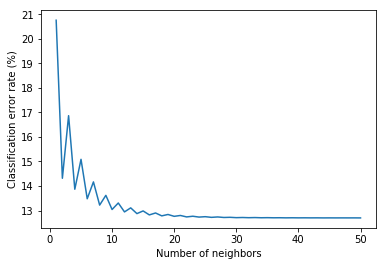

Cross validation fold: 8/10


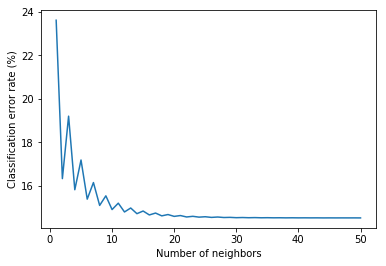

Cross validation fold: 9/10


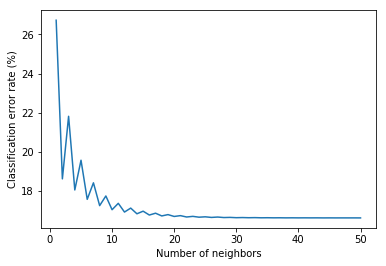

Cross validation fold: 10/10


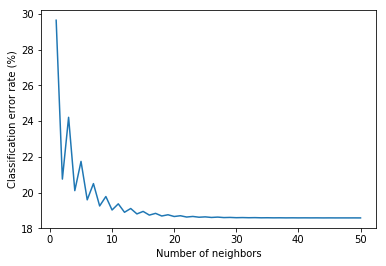

In [16]:
# Estimate model parameters for KNN using cross validation
# Maximum number of neighbors
K = 50
N = knn_dict['N']
# K-fold crossvalidation
K_fold = 10
CV = cross_validation.KFold(N, K_fold, shuffle = False)
#CV = cross_validation.LeaveOneOut(N)

errors = np.zeros((N, K))
i = 0
for train_index, test_index in CV:
    print 'Cross validation fold: {0}/{1}'.format(i + 1, CV.n_folds)
    
    # extract training and test set for current CV fold
    X_train = knn_dict['X'][train_index,:]
    y_train = knn_dict['y'][train_index]
    X_test = knn_dict['X'][test_index,:]
    y_test = knn_dict['y'][test_index]

    # Fit classifier and classify the test points (consider 1 to 40 neighbors)
    for k in range(1, K + 1):
        knclassifier = KNeighborsClassifier(n_neighbors = k);
        knclassifier.fit(X_train, y_train);
        y_est = knclassifier.predict(X_test);
        errors[i, k - 1] = np.sum(y_est != y_test)
    # 
    i +=1
    
    # if this does not work put the last section below a tab back!
    # Plot the classification error rate
    plt.plot(range(1,errors.shape[1] + 1), (100 * np.sum(errors,0) / N).tolist())
    plt.xlabel('Number of neighbors')
    plt.ylabel('Classification error rate (%)')
    plt.show()

## 3. Theory. Which theoretical tools did you use?


### - C) Explain the model performance. How did you measure it? Are your results what you expected?
From the graph above it is clear that when we training data increases the error rate also goes up. This indicats that more data leads to overfitting of the model. The best cross validation model shows a split of 1/10 between training and testing data.

Another clear trend is that the error rate for predictions drop significantly as the number of neighboors for the classification increases. However, the marginal increase in prediction rates plateau after 20 neighboors. Since more neighboors it could be argued that one should use 20 neighboors for the KNN analysis, even though the plots above show that the predictions become slightly more accurate as the number of neighbors reaches 50. 

In [17]:
# Fitting KKN for the complete observations
knn_dict['k_opt'] = np.argmin(np.sum(errors,0)) + 1
knn_dict['knn_opt_fit'] = KNeighborsClassifier(n_neighbors = knn_dict['k_opt']);

knn_dict['knn_opt_fit'].fit(knn_dict['X'], knn_dict['y']);
lat_min, lat_max = knn_dict['lat_min_max']
lon_min, lon_max = knn_dict['lon_min_max']

# use complete data to classify based upon the optimal split between training and test data from the cross validation 
pre = knn_dict['X'].tolist()
# prediction
Z = knn_dict['knn_opt_fit'].predict(pre)

# prepare the dictionary for the json format
pre_knn_dict = {}
pre_knn_dict['lat'] = [pre[ii][0] for ii in range(0,len(Z))]
pre_knn_dict['lon'] = [pre[ii][1] for ii in range(0,len(Z))]
pre_knn_dict['time'] = [pre[ii][2] for ii in range(0,len(Z))]
pre_knn_dict['month'] = [pre[ii][3] for ii in range(0,len(Z))]
pre_knn_dict['class'] = [Z[ii] for ii in range(0,len(Z))]

# add color to the dictionary
colorList = []
for value in list(pre_knn_dict['class']):
                  if value == False:
                      colorList.append("rgba(255,255,0,0.5)")
                  else:
                      colorList.append("rgba(255,0,0,0.5)")
knn_dict['color'] = colorList

knn_opt_json = [{'lat': pre_knn_dict['lat'][ii],
                 'lon': pre_knn_dict['lon'][ii],
                 'class': pre_knn_dict['class'][ii]} for ii in range(0,len(pre_knn_dict['class']))]
# create json file
createJSON(knn_opt_json, 'data/knn_opt_json.json') 

# prediction values when the parameters included are geodata, time, and month
tmp = collections.Counter(pre_knn_dict['class'])
print 'Non fatal accidents: {0:.3f}%'.format(tmp.values()[0] / np.sum(tmp.values()) * 100)
print 'Fatal accidents:     {0:.3f}%'.format(tmp.values()[1] / np.sum(tmp.values()) * 100)


Non fatal accidents: 99.997%
Fatal accidents:     0.003%


As seen from the split between non-lethal and lethal accidents, it's evident that non-fatal accidents are predicted almost everytime. One reason for this is that non-fatal are the majority of the observations in our data set. To counter this unbalance, we will create a balanced data set of observations between fatal - and non-fatals accidents. Another way to balance the overrepresentation of lethal accidents would be to change the number of nearest neighbors to 20. A smaller number of neighbors, should allow for more lethal accidents to be predicted. However, this also depends on the spread of the observations.

In [18]:
collections.Counter(knn_dict['class'])

Counter({0: 489592, 1: 111721})

### Balanced KNN calculations

In the hypothetical scenario in which fatal and non-fatal accidents are equally frequent, we've created a balanced KNN prediction. The code for the calculations and data preperation can be found below

In [19]:
# create indexes for balanced set of fatal and non-fatal accidents
fat_ind = []
nonfat_ind = []

for x in range(0,knn_dict['N']):
    if knn_dict['class'][x] == 1:
            fat_ind.append(x)
            
counter = 0
for x in range(0,knn_dict['N']):
    if counter < 111721:
        if knn_dict['class'][x] == 0:
            nonfat_ind.append(x)
            counter += 1

# combine the two sets of indexes
bal_ind = fat_ind + nonfat_ind

In [20]:
# use indexes to create new dictionary 
bal_dic = {}
bal_dic['lat'] = [knn_dict['lat'][ii] for ii in bal_ind]
bal_dic['lon'] = [knn_dict['lon'][ii] for ii in bal_ind]
bal_dic['class'] = [knn_dict['class'][ii] for ii in bal_ind]

In [21]:
# Plot the decision boundary - Latitude and longtitude values for New York City
y_max_lat = 40.730610 + 0.25
y_min_lat = 40.730610 - 0.25
x_min_lon = -73.935242 - 0.25
x_max_lon = -73.935242 + 0.25

# create meshgrid for unbalanced data set
h = 0.0011

# latitude mesh values
ygrid = []
y = y_min_lat
while y < y_max_lat:
    ygrid.append(y)
    y += h 

#longtitude mesh values
xgrid = []
x = x_min_lon
while x < x_max_lon:
    xgrid.append(x)
    x += h 

# create list including the lon and lat values
mesh = []
for gridy in ygrid:
    for gridx in xgrid:
        tmp = []
        tmp.append(gridy)
        tmp.append(gridx)
        mesh.append(tmp)
        
knn_dict['Mesh'] = mesh

In [22]:
# KNN dictionaries for predictions
bal_dic['X'] = np.array([[bal_dic['lat'][ii], bal_dic['lon'][ii]] for ii in range(0,len(bal_dic['lat']))])

In [23]:
# Fitting KKN for the complete observations
bal_dic['k_opt'] = np.argmin(np.sum(errors,0)) + 1
bal_dic['knn_opt_fit'] = KNeighborsClassifier(n_neighbors = knn_dict['k_opt']);

bal_dic['knn_opt_fit'].fit(bal_dic['X'], bal_dic['class']);
lat_min, lat_max = knn_dict['lat_min_max']
lon_min, lon_max = knn_dict['lon_min_max']

# use complete data to classify based upon the optimal split between training and test data from the cross validation 
balpre = bal_dic['X'].tolist()
# prediction
W = bal_dic['knn_opt_fit'].predict(balpre)

In [24]:
color_bal = []
for value in W:
    if value == False:
        color_bal.append("rgba(255,255,0,0.5)")
    else:
        color_bal.append("rgba(255,0,0,0.5)")

In [25]:
# calculate the percentage of non-lethal accidents out of the total predictions on balanced data
counter = 0
for value in W:
    if value == 0:
        counter += 1

print "percentage of non-lethal accidents predicted out of all preditions:", (counter/len(W) * 100),"%"

percentage of non-lethal accidents predicted out of all preditions: 49.2655812247 %


In [26]:
# create balanced KNN for D3
knn_bal_json = [{'lat': knn_dict['Mesh'][ii][0],
                 'lon': knn_dict['Mesh'][ii][1],
                 'color': color_bal[ii]} for ii in range(0,len(knn_dict['Mesh']))] 

# create small unbalanced KNN for D3
knn_bal_sm_json = knn_bal_json[0::3]

# create small json file for unbalanced KNN
createJSON(knn_bal_sm_json, 'data/knn_bal_sm_json.json')

# create large json file for balanced KNN
createJSON(knn_bal_json, 'data/knn_bal_json.json') 

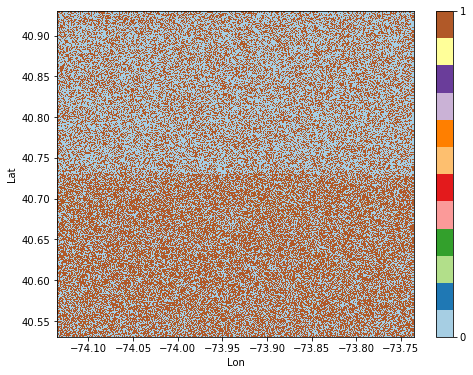

In [67]:
# import lib
import pylab as pl

# Plot the decision boundary - Latitude and longtitude values for New York City
y_max_lat = 40.730610 + 0.2
y_min_lat = 40.730610 - 0.2
x_min_lon = -73.935242 - 0.2
x_max_lon = -73.935242 + 0.2

# sample random predictions 
rand_smpl_W = np.array([ W[i] for i in sorted(random.sample(xrange(len(W)), 132496)) ])

# create mesh for the plot for balanced set
# Plot the decision boundary. For that, we will asign a color to each
xx_equal, yy_equal = np.meshgrid(np.arange(x_min_lon, x_max_lon, h), 
                                 np.arange(y_min_lat, y_max_lat, h))
# Put the result into a color plot
W_equal = rand_smpl_W.reshape(xx_equal.shape)
pl.figure(1, figsize=(8, 6))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx_equal, yy_equal, W_equal)
pl.colorbar(ticks = [0,1])

#pl.title("K = " + str(K))
pl.xlabel('Lon')
pl.ylabel('Lat')

pl.xlim(x_min_lon, x_max_lon)
pl.ylim(y_min_lat, y_max_lat)

pl.show()

As seen from the predictions in the balanced set, the distributions of fatal and non-fatal injuries seems to be randomly distributed, except a seperating line between 40.70 and 40.975 in which fatal injuries (value of 1) seems to appear more frequently on the southern part and vice versa. This seems quite odd, and might be an error on our part, due to the fact that we had to 

### Unbalanced KNN Predictions

Below are the code for the unbalanced KNN predictions

In [28]:
# create prediction of accident severity based upon longtitude and latitude information
knn_dict['k_opt'] = np.argmin(np.sum(errors,0)) + 1
# even though non-lethal observations are the majority
knn_dict['knn_opt_fit'] = KNeighborsClassifier(n_neighbors = 50);
#knn_dict['knn_opt_fit'] = KNeighborsClassifier(n_neighbors = knn_dict['k_opt']);

knn_dict['knn_opt_fit'].fit(knn_dict['Basic'], knn_dict['y']);
lat_min, lat_max = y_min_lat ,y_max_lat
lon_min, lon_max = x_min_lon, x_max_lon

pre = knn_dict['Mesh']
Q = knn_dict['knn_opt_fit'].predict(pre)

color_unbal = []
for value in Q:
    if value == False:
        color_unbal.append("rgba(255,255,0,0.5)")
    else:
        color_unbal.append("rgba(255,0,0,0.5)")

In [29]:
# create large unbalanced KNN for D3
knn_unbal_json = [{'lat': knn_dict['Mesh'][ii][0],
                 'lon': knn_dict['Mesh'][ii][1],
                 'color': color_unbal[ii]} for ii in range(0,len(knn_dict['Mesh']))] 

# create small unbalanced KNN for D3
knn_unbal_sm_json = knn_unbal_json[0::3]

# create large json file for unbalanced KNN
createJSON(knn_unbal_json, 'data/knn_unbal_json.json') 

# create small json file for unbalanced KNN
createJSON(knn_unbal_sm_json, 'data/knn_unbal_sm_json.json') 

In [30]:
# calculate the percentage of non-lethal accidents out of the total predictions on unbalanced data
counter = 0
for value in Q:
    if value == 0:
        counter += 1

print "percentage of non-lethal accidents predicted out of all preditions:", (counter/len(W) * 100),"%"

percentage of non-lethal accidents predicted out of all preditions: 92.6504417254 %


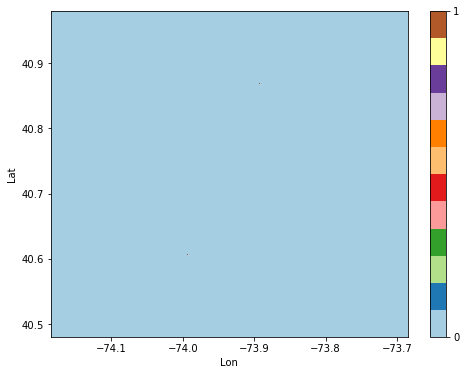

In [31]:
# Put the result into a color plot for unbalanced data set

# Plot the decision boundary - Latitude and longtitude values for New York City
y_max_lat = 40.730610 + 0.25
y_min_lat = 40.730610 - 0.25
x_min_lon = -73.935242 - 0.25
x_max_lon = -73.935242 + 0.25

# create mesh for the plot for balanced set
# Plot the decision boundary. For that, we will asign a color to each
xx_equal, yy_equal = np.meshgrid(np.arange(x_min_lon, x_max_lon, h), 
                                 np.arange(y_min_lat, y_max_lat, h))

Q_equal = Q[0:207025].reshape(xx_equal.shape)
pl.figure(1, figsize=(8, 6))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx_equal, yy_equal, Q_equal)
pl.colorbar(ticks = [0,1])

#pl.title("K = " + str(K))
pl.xlabel('Lon')
pl.ylabel('Lat')

pl.xlim(x_min_lon, x_max_lon)
pl.ylim(y_min_lat, y_max_lat)

pl.show()

As expected when predicting based on the unbalanced data set which consist of a majority of non-lethal accidents, the predictions also guess a similar outcome. 

# Decision Tree

A decision tree is a machine learning tool allowing you to identify the best possible combinations of questions, given specific parameters, in order to determine a certain outcome. As a decision tree keeps splitting between two outcomes, based on the entropy level, local optimums do occour. In this particular use case with New York City motorvehicle data, a decision tree is used to determine the right questions in the right order to ask, in order to identify a fatal accident. This could be applied in an situation in which someone reports an accident over the phone.

First step is to transformed the category input to integer values so it can be used by the scikit decision tree library. Of the different keys in the dictionary 'CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1', and 'BOROUGH' need to be converted into integer values

In [32]:
attr_list = ['CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1','BOROUGH','LATITUDE','LONGITUDE','TIME_DEC','MONTH' ]
categoryList = ['CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1','BOROUGH']

In [33]:
# create dictionary with unique values for the non-integer values
dt_dic = {}
for value in categoryList:
    uniqueCategoryList = list(set(raw_DF[value]))
    dt_dic[value] = uniqueCategoryList

dt_dic.keys()

['CONTRIBUTING FACTOR VEHICLE 1', 'BOROUGH', 'VEHICLE TYPE CODE 1']

In [34]:
# creating list for 'CONTRIBUTING FACTOR VEHICLE 1' in integer format
cfv_list = []
for value in raw_DF['CONTRIBUTING FACTOR VEHICLE 1']:
    for unique in range(0,len(dt_dic['CONTRIBUTING FACTOR VEHICLE 1'])):
                    if value == dt_dic['CONTRIBUTING FACTOR VEHICLE 1'][unique]:
                        cfv_list.append(unique)
                    

# creating list for 'BOROUGH' in integer format
brg_list = []
for value in raw_DF['BOROUGH']:
    for unique in range(0,len(dt_dic['BOROUGH'])):
                    if value == dt_dic['BOROUGH'][unique]:
                        brg_list.append(unique)

                    
# creating list for 'VEHICLE TYPE CODE 1' in integer format
vhc_list = []
for value in raw_DF['VEHICLE TYPE CODE 1']:
    for unique in range(0,len(dt_dic['VEHICLE TYPE CODE 1'])):
                    if value == dt_dic['VEHICLE TYPE CODE 1'][unique]:
                        vhc_list.append(unique)

# create lists for the attributes already stored in int format
lat_list = raw_DF['LATITUDE']
lon_list = raw_DF['LONGITUDE']
tim_list = raw_DF['TIME_DEC']
mon_list = raw_DF['MONTH']

In [35]:
# some values have missing attributes values, therefore the observation set is slightly smaller
newRange = min(len(vhc_list), len(brg_list), len(cfv_list))

In [36]:
newRange = 598440

In [37]:
# create list for decision tree
X = []
for inputs in range(0,newRange):
    X.append([vhc_list[inputs], brg_list[inputs], cfv_list[inputs], lat_list[inputs], lon_list[inputs], tim_list[inputs], mon_list[inputs]])

In [38]:
# boolean value (0 or 1) determining whether there were any fataly injured in the accident
Y = [raw_DF['KNN_bool'][ii] for ii in range(0,newRange)]

In [39]:
#split into test and train data: 90% train and 10% test data
K = 10
trainXData = X[:int((newRange/K)*9)]
trainYData = Y[:int((newRange/K)*9)]

testXData = X[int((newRange)/K)*9:]
testYData = Y[int((newRange)/K)*9:]

In [40]:
# import library
from sklearn import tree
# the model is trained with the data
clf = tree.DecisionTreeClassifier()
clf = clf.fit(trainXData, trainYData)

# create an array of predicted values based
predictedResults = clf.predict(testXData)

# calculate the accuracy based on the test data
counter = 0
for x in range(0, len(testYData)):
    if predictedResults[x] == testYData[x]:
        counter += 1
print 'The accuracy of the model in decimal points is: {0:.3f}%'.format(float(counter) / float(len(testYData))*100),"%"

# create decision tree pdf with the splits of depth of 3
from IPython.display import Image 
from sklearn.externals.six import StringIO
import pydot

##### max_d = 3
dot_data = StringIO()
tree.export_graphviz(clf, 
                     out_file = dot_data, 
                     feature_names = attr_list,  
                     filled=True, rounded=True,  
                     special_characters=True,
                     max_depth = 3)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
graph[0].write_pdf('dt_NYC.pdf')
#in notebook Image(graph[0].create_png())  

The accuracy of the model in decimal points is: 69.177% %


True

To view the decision tree, please visit the following link: <br>
https://github.com/titanbender/titanbender.github.io/blob/master/Images/dt_NYC.pdf

The accuracy of the 3-leaf decision tree is better above 50%. That is better than an average guess, but the same time it's only correct 70% of the time, according to the training and test data after asking three seperate questions. 

Create the json file for the d3 visualization

In [41]:
# create json file for d3 visualization
tree_json = {
  "name": "Vehicle Type < 2 (18.47% fatal)",
  "children": [
    {
      "name": "TRUE: Time of day < 8:00 (19.60% fatal)",
      "children": [
        {
          "name": "TRUE: Time of day < 8:00 (19.60% fatal)",
          "children": [
            {
            "name": "TRUE: Latitude < 40.7198 (23.90% fatal)" 
            },
            {
             "name": "FALSE: Month < 4 (18.17% fatal)"
            }
          ]
        },
        {
          "name": "FALSE: Longtitude < -73.9693 (16.37% fatal)",
          "children": [
            {
              "name": "TRUE: Latitude < 40.7453 (13.69% fatal)"
            },
            {
              "name": "FALSE: Month < June (18.52% fatal)"
            }
          ]
        }
      ]
    },
    {
      "name": " FALSE: Longtitude < -73.9527 (16.27% fatal)",
      "children": [
        {
          "name": " TRUE: Latitude < 40.7453 (13.69% fatal)",
          "children": [
            {
              "name": " TRUE: Longtitude < -73.9895 (15.68% fatal)"
            },
            {
              "name": " FALSE: Latitude < 40.7912 (11.72% fatal)"
            }
          ]
        },
        {
          "name": " FALSE: Time of day < 18:00 (18.52% fatal)",
          "children": [
            {
              "name": " TRUE: Time of day < 8:00 (17.44% fatal)"
            },
            {
              "name": " FALSE: Latitude < 40.7069 (21.99% fatal)"
            }
          ]
        }
      ]
    }
  ]
}
createJSON(tree_json,'data/tree.json')

As seen from the JSON file above, Vehicle Type is the most important parameter. As Vehicle Type is a categorical variable, which has been transformed to a numerical value, the list of values for the category has been listed in the order below

In [42]:
set(raw_DF['VEHICLE TYPE CODE 1'])

{nan,
 'AMBULANCE',
 'BICYCLE',
 'BUS',
 'FIRE TRUCK',
 'LARGE COM VEH(6 OR MORE TIRES)',
 'LIVERY VEHICLE',
 'MOTORCYCLE',
 'OTHER',
 'PASSENGER VEHICLE',
 'PEDICAB',
 'PICK-UP TRUCK',
 'SCOOTER',
 'SMALL COM VEH(4 TIRES) ',
 'SPORT UTILITY / STATION WAGON',
 'TAXI',
 'UNKNOWN',
 'VAN'}

## Heat map visualization for the website

In [44]:
geo_data = {}
geo_data['lat'] = list(raw_DF["LATITUDE"])
geo_data['lon'] = list(raw_DF["LONGITUDE"])

geoplotlib.kde(geo_data, bw = 2, cut_below=1e-4)

bbox = BoundingBox(north = np.mean(raw_DF["LATITUDE"]) + 0.232,
                   west = np.mean(raw_DF["LONGITUDE"]) - 0.232,
                   south = np.mean(raw_DF["LATITUDE"]) - 0.232,
                   east = np.mean(raw_DF["LONGITUDE"]) + 0.232)

geoplotlib.set_bbox(bbox)
#geoplotlib.tiles_provider('watercolor')
#geoplotlib.inline()
geoplotlib.savefig('data/heatmap')

('smallest non-zero count', 4.4777898101688105e-09)
('max count:', 55.088293082658367)


Generating a heatmap png image for the final presention

## 4. Visualizations
### - A) Explain the visualizations you've chosen.

A total of six visualizations have been chosen: A heatmap displaying the accident occurances throughout the years, a bar plot displaying accidents distributed over 24 hourly slots, a time series displaying occurances throughout the years, a scatter plot displaying the correlation between accidents and rain fall, a map displaying KNN predictions, and a decision tree showing the splits to detect fatal accidents.


### - B) Why are they right for the story you want to tell?

The overall goal of the project is to provide insights that empowers NYPD to better understand the accident data as well as potentially allow them to predict the severity of a reported accident. Below is a description of how each of the visualizations support this objective.

- A heatmap was chosen as it gives a visual overview of how accidents are distributed across the years. This allows the end-user to see if there are certain geographic patterns that repeat itself. <br> <br>

- A bar plot displaying accidents distributed over 24 hourly slots was chosen because it gives a great visual input to discovering patterns in accidents across the different hours of a day. <br> <br>

- A time series displaying occurances throughout the years was chosen because it gives the end-user the ability to visually explore seasonal patterns in the number of occourances. We decided to plot both non-fatal and fatal accidents together. However, since non-fatal accidents occour in much higher frequency, it is not as easy to visually grasp the trends for the fatal accidents in the graph. <br> <br>

- A scatter plot displaying the correlation between accidents and rain fall was chosen because it gives a clear visual understanding of how the two depend on each other. Based on this visualization (and the parameters of the linear regression), the end-user can determine whether rain fall has a significant impact or not. <br> <br>

- A map dsiplaying KNN predictions was chosen as it gives an overview of where fatal accidents are predicted. Since we already were working on geographic data, the choice seemed obvious. <br> <br>

- A decision tree showing the splits to detect fatal accidents was chosen as it provided insights into which attributes were most important in order to determine if an accident would have fatal consequences. Further, the decision tree could also be an applicable tool in terms of gathering the most important details once an accident is reported.


## 5. Discussion Think critically about your creation

### - What went well?

Three things in the project went well. First, we identifyed a range of interesting questions regarding traffic accidents (see vimeo video in the beginning) that could be answered based upon two different data sets. Secondly, we managed to complete a wide range of data visualizations that covered both the data explorative part, but also the predictive elements. Third, we were able to identify interesting patterns within the data such as the correlations between accidents and weather data, which hours during the day include the most accidents and which parameters best determine if an accident is fatal.

### - What is still missing? What could be improved?, Why?

As the dataset was very large and we decided to examine multiple hypothesis, it didn't allow us to dive as deep into the different visualizations and calculations as we would have liked. As the data analysis part took up a lot of time, more time could have been used to prepare the data story website part. The code could also be more polished in order to minimize length and time to compute. Another issue that took a lot of time and ultimately lead to the website to be seperated into sub pages were the conflicts generated with using visualization powered by d3.v3 and d3.v4 respectively. Lastly, the code in this notebook could have been cleaned more. 